In [1]:
import os
import json
import torch
import pickle
import numpy as np
from PIL import Image, ImageFilter 
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



cuda:0


## Load the data from RefCOCOg

Here we load the annotation file with all the references and the images. 

In [ ]:
with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  annotations = pickle.load(fp)

  train_data = sorted([d for d in annotations if d["split"]=="train"], key=lambda d: d["file_name"])
  val_data = sorted([d for d in annotations if d["split"]=="val"], key=lambda d: d["image_id"])
  test_data = sorted([d for d in annotations if d["split"]=="test"], key=lambda d: d["image_id"])

  entry = train_data[0]

  print(json.dumps(entry, indent=4, default=str))



Here the data loader class.

In [2]:
import os
import json

from torch.utils.data import Dataset

class RefCOCOg(Dataset):
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]
    
    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [3]:
# Load refs and annotations
import pickle

with open("../extractCOCO/refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

with open("../extractCOCO/refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [4]:
# load the train dataset
train_dataset = RefCOCOg(refs=refs, annotations=annotations, split="train")

print(train_dataset[0])
print(train_dataset)
print(len(train_dataset))
train_dataset(0)

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
42226
{
    "file_name": "./refcocog/images/COCO_train2014_000000519404.jpg",
    "caption": "Two woman one in black eatting and the other has a white shirt at the desk",
    "ann_id": 1241542,
    "bbox": [
        0.0,
        45.95,
        238.92,
        408.64
    ]
}


Functions wich perform the blurring.

The carrots toward the front of the picture.
./refcocog/images/COCO_train2014_000000564050.jpg
[142.39, 239.66, 262.82, 169.65]


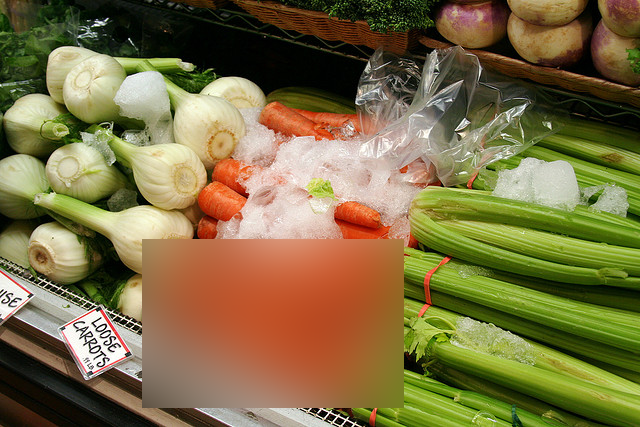

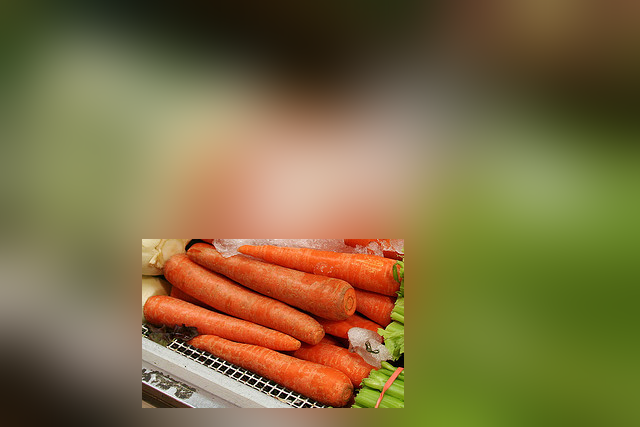

In [5]:
def blur_out(image, box):
    """ Blur the image out of the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(im))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_min)+int(y_max)
    x_1, x_2 = int(x_min), int(x_min)+int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2]-im[y_1:y_2,x_1:x_2]
    im[y_1:y_2,x_1:x_2] = im[y_1:y_2,x_1:x_2] + mask[y_1:y_2,x_1:x_2]

    # return the image blurred
    return Image.fromarray(im)


def blur_in(image, box):
    """ Blur the image in the bounding box
    
    """
    x_min, y_min, x_max, y_max = box

    # blur the image
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))

    # create the mask
    mask = np.zeros_like(np.array(im))

    # get blur image out of the bounding box
    y_1, y_2 = int(y_min), int(y_min)+int(y_max)
    x_1, x_2 = int(x_min), int(x_min)+int(x_max)

    # blur the image
    mask[y_1:y_2,x_1:x_2] = np.array(image)[y_1:y_2,x_1:x_2]

    # blur the image in the box
    remove_box = np.array(image)-mask
    im = np.array((image).filter(ImageFilter.GaussianBlur(radius = 30)))
    remove_box[y_1:y_2,x_1:x_2] = remove_box[y_1:y_2,x_1:x_2] + np.array(im)[y_1:y_2,x_1:x_2]

    return Image.fromarray(remove_box)

sample = train_dataset[500]
print(sample["caption"])
print(sample["file_name"])
print(sample["bbox"])

# extract the image
img = Image.open('../extractCOCO/'+sample["file_name"][1:])
blur_in(img, sample["bbox"]).show()
blur_out(img, sample["bbox"]).show()


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import numpy as np
import tqdm.auto as tqdm

In [39]:
def iou(box1, box2):
    """ Compute the IoU given two bounding boxes.

    Args:
        box1 (list): [x1, y1, x2, y2] coordinates of first bounding box.
        box2 (list): [x1, y1, x2, y2] coordinates of second bounding box.

    Returns:
        iou_score float: Intersection over Union (IoU) score.
    """

    # Pick the intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1_area + box2_area - intersection

    # Calculate IoU score
    iou_score = intersection / union

    return iou_score

def compute_tp_fp_fn(predictions, targets, iou_threshold=0.5):
    """ Produce the true positives (TP), false positives (FP), and false 
    negatives (FN) for a set of predicted and ground truth bounding boxes.

    Parameters:
        predictions (list): List of predicted bounding boxes.
        targets (list): List of ground truth bounding boxes.
        iou_threshold (float): IoU threshold for matching predicted and ground truth bounding boxes.

    Returns:
        (tp, fp, fn) (tuple): Tuple containing TP, FP, and FN values.
    """

    # Initialize arrays for true positives and false positives
    tp = np.zeros(len(predictions))
    fp = np.zeros(len(predictions))

    # Initialize array for matched ground truth boxes
    matched_targets = np.zeros(len(targets))

    # Compute true positives and false positives
    for i, (p, t) in enumerate(zip(predictions, targets)):
        index = -1
        if matched_targets[i] == 0 and iou(p, t) >= iou_threshold:
            index = i

        if index != -1:
            # This predicted box is a true positive
            tp[i] = 1
            matched_targets[index] = 1
        else:
            # This predicted box is a false positive
            fp[i] = 1

    # Compute false negatives
    fn = np.ones(len(targets)) - matched_targets

    return tp, fp, fn

p=[[0,0, 10, 100],[0,0, 10, 100],[0,0, 10, 100],[0,0, 10, 100]]
t=[[0,0, 10, 100],[0,0, 10, 100],[0,0, 10, 100],[0,0, 100, 100]]

tp, fp, fn = compute_tp_fp_fn(p,t, iou_threshold=0.5)


precision = tp.sum() / (tp.sum() + fp.sum())
recall = tp.sum() / (tp.sum() + fn.sum())

print('precision:',precision)
print('recall:',recall)

f1_score = 2 * (precision * recall) / (precision + recall)

print('f1_score:',f1_score)


precision: 0.75
recall: 0.75
f1_score: 0.75


In [7]:
import torch

target_boxes = torch.load('data_refcoco/full/target_boxes.pt')
prob_boxes = torch.load('data_refcoco/full/prob_boxes.pt')
boxes_emb = torch.load('data_refcoco/full/boxes_emb.pt')
caption_emb = torch.load('data_refcoco/full/caption_emb.pt')

In [8]:
# extract only the boxes which for CLIP best match with the caption
listed_prob_boxes_0 = [prob_boxe[0,2:].type(torch.int16).tolist() for prob_boxe in prob_boxes]
listed_prob_boxes = [prob_boxe[0,2:].type(torch.int16).tolist() for prob_boxe in prob_boxes]
listed_prob_boxes_1 = [prob_boxe[1,2:].type(torch.int16).tolist() for prob_boxe in prob_boxes]
listed_prob = [prob_boxe[:,0].tolist() for prob_boxe in prob_boxes]
listed_target_boxes = [box.type(torch.int16).tolist() for box in target_boxes]

In [9]:
list(zip(listed_prob_boxes, listed_target_boxes))[:10]

[([1, 41, 244, 426], [0, 46, 239, 409]),
 ([210, 459, 195, 130], [214, 457, 192, 134]),
 ([96, 49, 356, 238], [94, 46, 348, 230]),
 ([35, 80, 265, 215], [39, 78, 279, 217]),
 ([47, 269, 97, 175], [273, 144, 339, 355]),
 ([0, 1, 207, 336], [60, 106, 317, 245]),
 ([0, 2, 444, 474], [207, 228, 172, 240]),
 ([181, 64, 226, 571], [0, 471, 370, 109]),
 ([106, 121, 268, 121], [104, 118, 267, 125]),
 ([0, 75, 219, 270], [25, 60, 314, 284])]

In [ ]:
for b0, b1, p in zip(listed_prob_boxes_0,listed_prob_boxes_1,np.array(listed_prob)):
    b0 = np.array(b0)
    b1 = np.array(b1)
    p = np.array(p)

    b0*p[0]+b1*p[1]
    print(b0,b1,p,b0*p[0]+b1*p[1])

Sometimes it happens that CLIP does not work well and does not get a score that properly reflects the sort of the boxes. As we can see here frequently we get that the second box is the one with the highest score.

In [10]:
print(prob_boxes[4][:,:2])
print(prob_boxes[4][:,2:])
print(target_boxes[4])

tensor([[0.6479, 0.0316],
        [0.1359, 0.0717]], dtype=torch.float16)
tensor([[ 47., 269.,  97., 175.],
        [270., 148., 329., 330.]], dtype=torch.float16)
tensor([273., 144., 339., 355.], dtype=torch.float16)


In [11]:
print(prob_boxes[9][:,:2])
print(prob_boxes[9][:,2:])
print(target_boxes[9])

tensor([[0.6016, 0.0007],
        [0.3376, 0.0011]], dtype=torch.float16)
tensor([[ -0.,  75., 219., 270.],
        [  1.,  71., 336., 274.]], dtype=torch.float16)
tensor([ 25.,  60., 314., 284.], dtype=torch.float16)


In [12]:
# compute the IoU between the boxes
m_iou = abs(np.array([iou(predicted, target) for predicted, target in zip(listed_prob_boxes, listed_target_boxes)])).mean()
min_iou = abs(np.array([iou(predicted, target) for predicted, target in zip(listed_prob_boxes, listed_target_boxes)])).min()
max_iou = abs(np.array([iou(predicted, target) for predicted, target in zip(listed_prob_boxes, listed_target_boxes)])).max()

print()

print('mean IoU:',m_iou)
print('min IoU:',min_iou)
print('max IoU:',max_iou)

# compute the true positive, false positive and false negative
tp, fp, fn = compute_tp_fp_fn(listed_prob_boxes,listed_target_boxes, iou_threshold=0.5)

precision = tp.sum() / (tp.sum() + fp.sum())
recall = tp.sum() / (tp.sum() + fn.sum())

print()

print('precision:',precision)
print('recall:',recall)

f1_score = 2 * (precision * recall) / (precision + recall)

print('f1_score:',f1_score)


mean IoU: 0.20145301142270056
min IoU: 0.0
max IoU: 1.0

precision: 0.21337448559670782
recall: 0.21337448559670782
f1_score: 0.21337448559670782


In [27]:
list(zip(listed_prob_boxes, listed_target_boxes))[:10]

[([1, 41, 244, 426], [0, 46, 239, 455]),
 ([210, 459, 195, 130], [214, 457, 406, 591]),
 ([96, 49, 356, 238], [94, 46, 442, 276]),
 ([35, 80, 265, 215], [39, 78, 318, 295]),
 ([47, 269, 97, 175], [273, 144, 612, 499]),
 ([0, 1, 207, 336], [60, 106, 377, 351]),
 ([0, 2, 444, 474], [207, 228, 379, 468]),
 ([182, 64, 226, 571], [0, 471, 370, 580]),
 ([106, 121, 268, 121], [104, 118, 371, 243]),
 ([0, 75, 219, 270], [25, 60, 339, 344])]

In [28]:
# change the scale of the boxes
import torch

target_boxes = torch.load('data_refcoco/full/target_boxes.pt')
prob_boxes = torch.load('data_refcoco/full/prob_boxes.pt')

prob_boxes[:,0,2] = prob_boxes[:,0,2] + prob_boxes[:,0,0]
prob_boxes[:,0,3] = prob_boxes[:,0,3] + prob_boxes[:,0,1]
target_boxes[:,2] = target_boxes[:,2] + target_boxes[:,0]
target_boxes[:,3] = target_boxes[:,3] + target_boxes[:,1]

# compute the IoU between the boxes
listed_target_boxes = [box.type(torch.int16).tolist() for box in target_boxes]
listed_prob_boxes = [prob_boxe[0,2:].type(torch.int16).tolist() for prob_boxe in prob_boxes]

# compute the IoU between the boxes
m_iou = abs(np.array([iou(predicted, target) for predicted, target in zip(listed_prob_boxes, listed_target_boxes)])).mean()
min_iou = abs(np.array([iou(predicted, target) for predicted, target in zip(listed_prob_boxes, listed_target_boxes)])).min()
max_iou = abs(np.array([iou(predicted, target) for predicted, target in zip(listed_prob_boxes, listed_target_boxes)])).max()

print()

print('mean IoU:',m_iou)
print('min IoU:',min_iou)
print('max IoU:',max_iou)

# compute the true positive, false positive and false negative
tp, fp, fn = compute_tp_fp_fn(listed_prob_boxes,listed_target_boxes, iou_threshold=0.5)

precision = tp.sum() / (tp.sum() + fp.sum())
recall = tp.sum() / (tp.sum() + fn.sum())

print()

print('precision:',precision)
print('recall:',recall)

f1_score = 2 * (precision * recall) / (precision + recall)

print('f1_score:',f1_score)


mean IoU: 0.13401600925908103
min IoU: 0.0
max IoU: 0.9966887417218543

precision: 0.39423868312757204
recall: 0.39423868312757204
f1_score: 0.39423868312757204


In [29]:
def iou(box1, box2):
    """ Compute the IoU given two bounding boxes.

    Args:
        box1 (list): [x1, y1, x2, y2] coordinates of first bounding box.
        box2 (list): [x1, y1, x2, y2] coordinates of second bounding box.

    Returns:
        iou_score float: Intersection over Union (IoU) score.
    """

    # Pick the intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate intersection area
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # Calculate union area
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = box1_area + box2_area - intersection

    # Calculate IoU score
    iou_score = intersection / union

    return iou_score

def compute_tp_fp_fn(predictions, targets, iou_threshold=0.5):
    """ Produce the true positives (TP), false positives (FP), and false 
    negatives (FN) for a set of predicted and ground truth bounding boxes.

    Parameters:
        predictions (list): List of predicted bounding boxes.
        targets (list): List of ground truth bounding boxes.
        iou_threshold (float): IoU threshold for matching predicted and ground truth bounding boxes.

    Returns:
        (tp, fp, fn) (tuple): Tuple containing TP, FP, and FN values.
    """

    # Initialize arrays for true positives and false positives
    tp = np.zeros(len(targets))
    fp = np.zeros(len(targets))

    # Initialize array for matched ground truth boxes
    matched_targets = np.zeros(len(targets))

    # Compute true positives and false positives
    for i, (p, t) in enumerate(zip(predictions, targets)):
        index = -1
        if matched_targets[i] == 0 and iou(p[0], t) >= iou_threshold:
            index = i
        elif matched_targets[i] == 0 and iou(p[1], t) >= iou_threshold:
            index = i

        if index != -1:
            # This predicted box is a true positive
            tp[i] = 1
            matched_targets[index] = 1
        else:
            # This predicted box is a false positive
            fp[i] = 1

    # Compute false negatives
    fn = np.ones(len(targets)) - matched_targets

    return tp, fp, fn


import torch

target_boxes = torch.load('data_refcoco/full/target_boxes.pt')
prob_boxes = torch.load('data_refcoco/full/prob_boxes.pt')
boxes_emb = torch.load('data_refcoco/full/boxes_emb.pt')
caption_emb = torch.load('data_refcoco/full/caption_emb.pt')

# extract only the boxes which for CLIP best match with the caption
listed_prob_boxes_0 = [prob_boxe[0,2:].type(torch.int16).tolist() for prob_boxe in prob_boxes]
listed_prob_boxes = [prob_boxe[0,2:].type(torch.int16).tolist() for prob_boxe in prob_boxes]
listed_prob_boxes_1 = [prob_boxe[1,2:].type(torch.int16).tolist() for prob_boxe in prob_boxes]
listed_prob = [prob_boxe[:,0].tolist() for prob_boxe in prob_boxes]
listed_target_boxes = [box.type(torch.int16).tolist() for box in target_boxes]

# compute the IoU between the boxes
m_iou = abs(np.array([max(iou(predicted[0], target),iou(predicted[1], target)) for predicted, target in zip(list(zip(listed_prob_boxes_0,listed_prob_boxes_1)), listed_target_boxes)])).mean()
min_iou = abs(np.array([max(iou(predicted[0], target),iou(predicted[1], target)) for predicted, target in zip(list(zip(listed_prob_boxes_0,listed_prob_boxes_1)), listed_target_boxes)])).min()
max_iou = abs(np.array([max(iou(predicted[0], target),iou(predicted[1], target)) for predicted, target in zip(list(zip(listed_prob_boxes_0,listed_prob_boxes_1)), listed_target_boxes)])).max()

print()

print('mean IoU:',m_iou)
print('min IoU:',min_iou)
print('max IoU:',max_iou)

# compute the true positive, false positive and false negative
tp, fp, fn = compute_tp_fp_fn(list(zip(listed_prob_boxes_0,listed_prob_boxes_1)),listed_target_boxes, iou_threshold=0.5)

precision = tp.sum() / (tp.sum() + fp.sum())
recall = tp.sum() / (tp.sum() + fn.sum())

print()

print('precision:',precision)
print('recall:',recall)

f1_score = 2 * (precision * recall) / (precision + recall)

print('f1_score:',f1_score)


mean IoU: 0.2612602020611374
min IoU: 0.0
max IoU: 1.0

precision: 0.3567901234567901
recall: 0.3567901234567901
f1_score: 0.3567901234567901
